# <span style="color:blue">Segmenting and Clustering Neighborhoods in Novi</span>

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# Seaborn
import seaborn as sns
sns.set()

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

## <span style="color:blue">Population:</span>

In [2]:
population_html = requests.get('https://api.opendatanetwork.com/data/v1/values?app_token=cQovpGcdUT1CSzgYk0KPYdAI0&describe=true&forecast=5&format=google&variable=demographics.population.count&entity_id=1600000US2659440').text
soup_population = BeautifulSoup(population_html,'lxml')

str_pop = soup_population.p.text
#str_pop

**Create a function to convert json into list**

In [3]:
def json2list(str_data):
    dict_data = json.loads(str_data)
    data_rows = dict_data['data']['rows']
    
    v0 = []
    v1 = []
    
    for i in range(len(data_rows)):
        data_row = data_rows[i]['c']
        v0.append(data_row[0]['v'])
        v1.append(data_row[1]['v'])
    
    return v0, v1

**Create "Year" and "Population" list**

In [4]:
year, population = json2list(str_pop)

year = year[0:10]
population = population[0:10]

df_pop = pd.DataFrame(year,columns=['Year'])
df_pop['Population'] = population

df_pop

,Year,Population
0,2009,53705.00
1,2010,53823.00
2,2011,54446.00
3,2012,55319.00
4,2013,56131.00
5,2014,56887.00
6,2015,57577.00
7,2016,58233.00
8,2017,58835.00
9,2018,59476.25


#### Population Change:

In [5]:
pop_chg = []
for i in range(len(df_pop['Population'])-1):
    pop_chg.append((df_pop['Population'][i+1]-df_pop['Population'][i])/
                   df_pop['Population'][i]*100)
year = df_pop.loc[1:,'Year']

Text(0.5, 1.0, 'Population Change in Novi, MI 2009-2018')

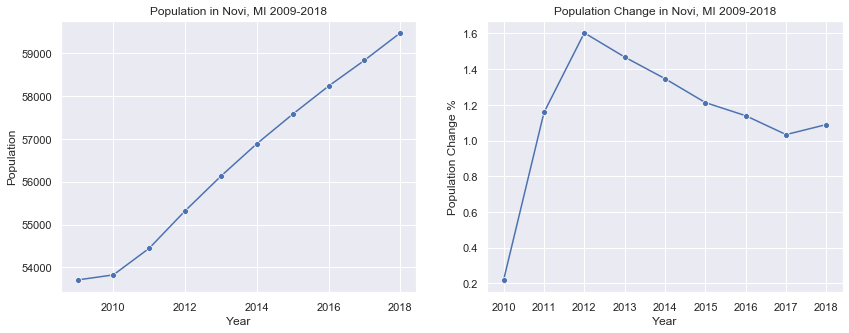

In [6]:
fig1 = plt.figure(figsize=(14,5))
ax1 = fig1.add_subplot(1,2,1)
ax2 = fig1.add_subplot(1,2,2)

sns.lineplot(x='Year',y='Population',data=df_pop,marker="o",ax=ax1)
ax1.set_title('Population in Novi, MI 2009-2018')

sns.lineplot(x=year,y=pop_chg,marker="o",ax=ax2)
ax2.set_xlabel('Year')
ax2.set_ylabel('Population Change %')
ax2.set_title('Population Change in Novi, MI 2009-2018')

## <span style="color:blue">Earnings and Gender</span>

In [7]:
earning_html = requests.get('https://api.opendatanetwork.com/data/v1/values?app_token=cQovpGcdUT1CSzgYk0KPYdAI0&describe=true&format=google&variable=jobs.earnings.median_earnings%2Cjobs.earnings.female_median_earnings%2Cjobs.earnings.male_median_earnings&entity_id=1600000US2659440&year=2016').text
soup_earning = BeautifulSoup(earning_html,'lxml')

str_earning = soup_earning.p.text
#str_earning

In [8]:
gender_name, earning = json2list(str_earning)
gender_name = [w.replace('_',' ') for w in gender_name] # get rid of '_' in the name

df_gender = pd.DataFrame(earning,index=gender_name,columns=['Earning'])
df_gender

,Earning
female median earnings,36142
male median earnings,72766
median earnings,52249


## <span style="color:blue">Earnings and Education</span>

In [9]:
earning_html = requests.get('https://api.opendatanetwork.com/data/v1/values?app_token=cQovpGcdUT1CSzgYk0KPYdAI0&describe=true&format=google&variable=jobs.earnings.median_earnings_less_than_high_school%2Cjobs.earnings.median_earnings_high_school%2Cjobs.earnings.median_earnings_some_college_or_associates%2Cjobs.earnings.median_earnings_bachelor_degree%2Cjobs.earnings.median_earnings_graduate_or_professional_degree&entity_id=1600000US2659440&year=2016').text
soup_earning = BeautifulSoup(earning_html,'lxml')

str_earning = soup_earning.p.text

In [10]:
edu, earning = json2list(str_earning)
edu = [w.replace('_',' ') for w in edu] # get rid of '_' in the name
edu

df_edu = pd.DataFrame(edu,columns=['Education'])
df_edu['Earnings'] = earning
df_edu

,Education,Earnings
0,median earnings bachelor degree,69651
1,median earnings graduate or professional degree,89234
2,median earnings high school,30475
3,median earnings less than high school,14514
4,median earnings some college or associates,39578


Text(0.5, 1.0, 'Earnings and Education in Novi, MI 2017')

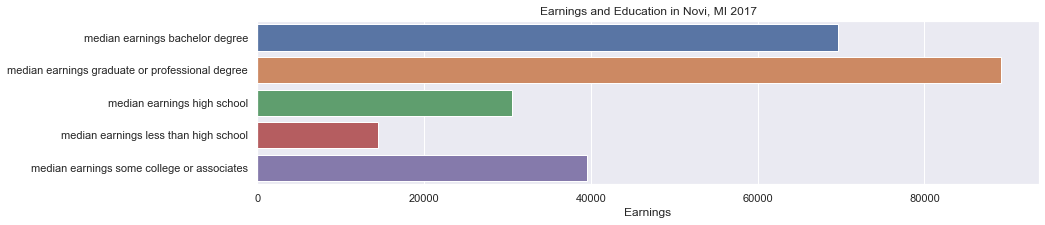

In [11]:
fig3 = plt.figure(figsize=(14,3))
ax = fig3.add_subplot(1,1,1)
sns.barplot(x='Earnings',y='Education',data=df_edu,ax=ax)

ax.set_xlabel('Earnings')
ax.set_ylabel('')
ax.set_title('Earnings and Education in Novi, MI 2017')

## <span style="color:blue">Finance Economy</span>

* Debt refers to the total amount of outstanding dollars owed by a government entity.

* Debt Per Capita is the amount of outstanding debt per resident.

* Long Term Debt is the unmatured principal of bonds, warrants, notes, or other forms of noncurrent or long-term obligation indebtedness.

* Debt Service Ratio is the percentage of annual revenues committed to paying back debts.

* Debt as a Percentage of Taxable Value is the amount of long term debt compared to taxable value.

* Long Term Debt Revenue is the ratio of outstanding long term debts to revenues.

### Debt Per Capita

In [12]:
debt_capita_html = requests.get('https://api.opendatanetwork.com/data/v1/values?app_token=cQovpGcdUT1CSzgYk0KPYdAI0&describe=true&format=google&variable=finance.michigan_debt.debt_health&entity_id=1600000US2659440').text
soup_debt_capita = BeautifulSoup(debt_capita_html,'lxml')

str_debt_capita = soup_debt_capita.p.text

In [13]:
year, amount = json2list(str_debt_capita)

df_debt_capita = pd.DataFrame(year,columns=['Year'])
df_debt_capita['Debt Per Capita'] = amount

### Long Term Debt

In [14]:
long_debt_html = requests.get('https://api.opendatanetwork.com/data/v1/values?app_token=cQovpGcdUT1CSzgYk0KPYdAI0&describe=true&format=google&variable=finance.michigan_debt.debt_long_term&entity_id=1600000US2659440').text
soup_long_debt = BeautifulSoup(long_debt_html,'lxml')

str_long_debt = soup_long_debt.p.text

In [15]:
year, amount = json2list(str_long_debt)

df_long = pd.DataFrame(year,columns=['Year'])
df_long['Long Term Debt'] = amount

In [16]:
df_long = pd.merge(df_long,df_pop,on='Year')

### Debt Service

In [17]:
debt_s_html = requests.get('https://api.opendatanetwork.com/data/v1/values?app_token=cQovpGcdUT1CSzgYk0KPYdAI0&describe=true&format=google&variable=finance.michigan_debt.debt_service&entity_id=1600000US2659440').text
soup_debt_s = BeautifulSoup(debt_s_html,'lxml')

str_debt_s = soup_debt_s.p.text

In [18]:
year, pct = json2list(str_debt_s)
pct = [x * 100 for x in pct]

df_debt_s = pd.DataFrame(year,columns=['Year'])
df_debt_s['Debt Service %'] = pct

### Debt as % of Taxable Value

In [19]:
debt_p_html = requests.get('https://api.opendatanetwork.com/data/v1/values?app_token=cQovpGcdUT1CSzgYk0KPYdAI0&describe=true&format=google&variable=finance.michigan_debt.debt_taxable_value&entity_id=1600000US2659440').text
soup_debt_p = BeautifulSoup(debt_p_html,'lxml')

str_debt_p = soup_debt_p.p.text

year, pct = json2list(str_debt_p)
pct = [x * 100 for x in pct]

df_debt_p = pd.DataFrame(year,columns=['Year'])
df_debt_p['Debt % of Taxable value'] = pct

### Long Term Debt Revenue

In [20]:
debt_r_html = requests.get('https://api.opendatanetwork.com/data/v1/values?app_token=cQovpGcdUT1CSzgYk0KPYdAI0&describe=true&format=google&variable=finance.michigan_debt.long_term_debt_revenue&entity_id=1600000US2659440').text
soup_debt_r = BeautifulSoup(debt_r_html,'lxml')

str_debt_r = soup_debt_r.p.text

year, pct = json2list(str_debt_r)
pct = [x * 100 for x in pct]

df_debt_r = pd.DataFrame(year,columns=['Year'])
df_debt_r['Debt % Revenue'] = pct

### Novi Economy Summary

In [21]:
df_novi = pd.merge(df_long,df_debt_capita,on='Year')
df_novi = pd.merge(df_novi,df_debt_s,on='Year')
df_novi = pd.merge(df_novi,df_debt_p,on='Year')
df_novi = pd.merge(df_novi,df_debt_r,on='Year')

df_novi

,Year,Long Term Debt,Population,Debt Per Capita,Debt Service %,Debt % of Taxable value,Debt % Revenue
0,2010,64613290,53823.0,1170.02,12.0,2.000000,76.0
1,2011,55925472,54446.0,1006.16,12.0,1.000000,66.0
2,2012,48022654,55319.0,843.80,11.0,1.000000,60.0
3,2013,41379833,56131.0,713.93,8.0,1.000000,49.0
4,2014,37695000,56887.0,645.28,5.0,1.000000,40.0
5,2015,32870000,57577.0,559.74,5.0,1.000000,32.0
6,2016,27235000,58233.0,459.96,13.0,0.825766,23.0
7,2017,23400000,58835.0,391.86,3.0,0.678238,24.0


### Finance Economy Visualization

Text(0.5, 1.0, 'Long Term Debt to Revenue in Novi, MI 2010-2017')

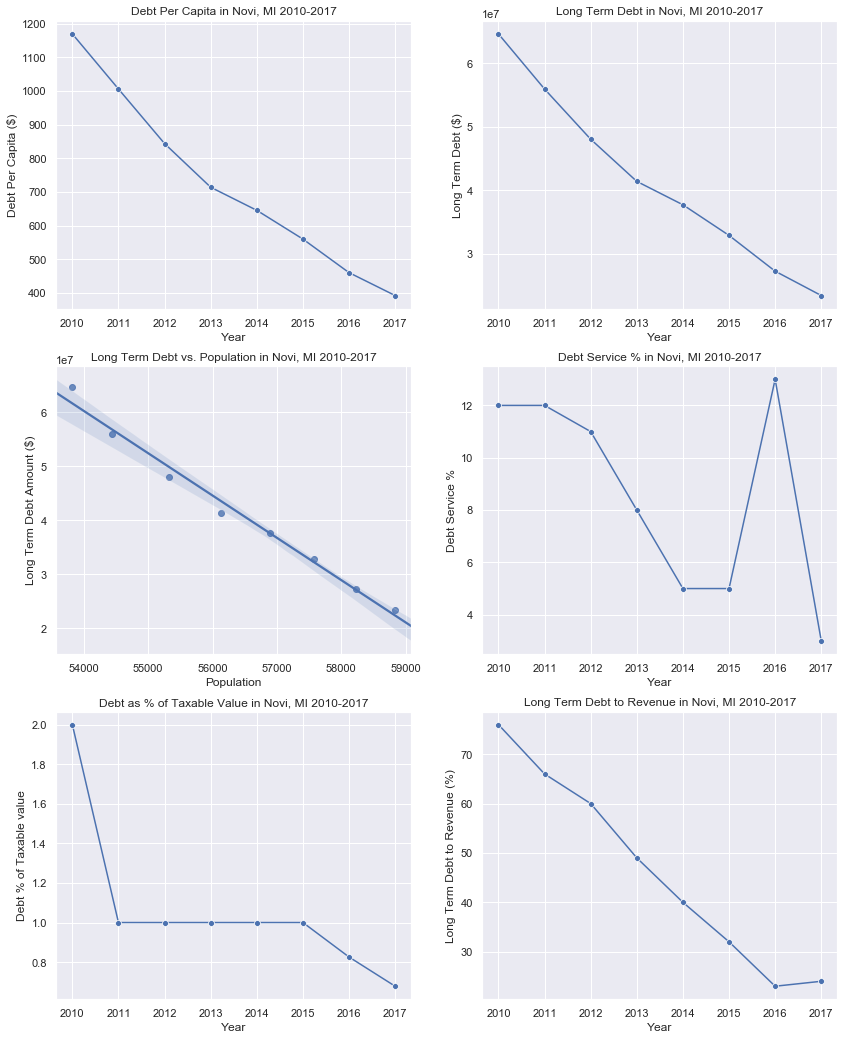

In [22]:
fig4 = plt.figure(figsize=(14,18))
ax1 = fig4.add_subplot(3,2,1)
ax2 = fig4.add_subplot(3,2,2)
ax3 = fig4.add_subplot(3,2,3)
ax4 = fig4.add_subplot(3,2,4)
ax5 = fig4.add_subplot(3,2,5)
ax6 = fig4.add_subplot(3,2,6)

# Debt Per Capita in Novi, MI 2010-2017
sns.lineplot(x='Year',y='Debt Per Capita',data=df_novi,marker='o',ax=ax1)
ax1.set_ylabel('Debt Per Capita ($)')
ax1.set_title('Debt Per Capita in Novi, MI 2010-2017')

# Long Term Debt in Novi, MI 2010-2017
sns.lineplot(x='Year',y='Long Term Debt',data=df_novi,marker='o',ax=ax2)
ax2.set_ylabel('Long Term Debt ($)')
ax2.set_title('Long Term Debt in Novi, MI 2010-2017')

# Long Term Debt vs. Population in Novi, MI 2010-2017
sns.regplot(x='Population', y='Long Term Debt', data=df_novi,ax=ax3)
ax3.set_ylabel('Long Term Debt Amount ($)')
ax3.set_title('Long Term Debt vs. Population in Novi, MI 2010-2017')

# Debt Service % in Novi, MI 2010-2017
sns.lineplot(x='Year',y='Debt Service %',data=df_novi,marker='o',ax=ax4)
ax4.set_title('Debt Service % in Novi, MI 2010-2017')

# Debt as % of Taxable Value in Novi, MI 2010-2017
sns.lineplot(x='Year',y='Debt % of Taxable value',data=df_novi,marker='o',ax=ax5)
ax5.set_title('Debt as % of Taxable Value in Novi, MI 2010-2017')

# Long Term Debt Revenue in Novi, MI 2010-2017
ax6.clear()
sns.lineplot(x='Year',y='Debt % Revenue',data=df_novi,marker='o',ax=ax6)
ax6.set_ylabel('Long Term Debt to Revenue (%)')
ax6.set_title('Long Term Debt to Revenue in Novi, MI 2010-2017')

## <span style="color:blue">Crime Incident</span>

In [23]:
crime_html = requests.get('https://api.opendatanetwork.com/data/v1/values?app_token=cQovpGcdUT1CSzgYk0KPYdAI0&describe=true&format=google&variable=crime.fbi_ucr.count&entity_id=1600000US2659440&year=2016').text
soup_crime = BeautifulSoup(crime_html,'lxml')

str_crime = soup_crime.p.text
#str_crime

**Use json2list to convert str into list**

In [24]:
crime_name, count = json2list(str_crime)
del crime_name[1]
del count[1]
#crime_name

df_crime = pd.DataFrame(crime_name,columns=['Crime'])
df_crime['Count'] = count

df_crime

,Crime,Count
0,Aggravated assault,24
1,Arson,0
2,Burglary,56
3,Larceny,586
4,Motor vehicle theft,19
5,Murder and nonnegligent manslaughter,0
6,Property crime,661
7,Rape (revised definition),6
8,Robbery,2
9,Violent crime,32


## <span style="color:blue">Crime Incident Rate per 100,000 People</span>

In [25]:
df_crime['Count Rate'] = df_crime['Count']/df_pop.loc[8,'Population']*100000

Text(0.5, 1.0, 'Crime Incident Rate per 100,000 People in Novi, MI 2017')

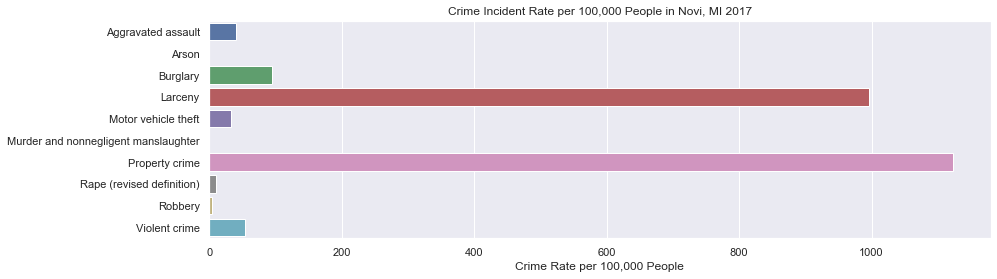

In [26]:
fig2 = plt.figure(figsize=(14,4))
ax2 = fig2.add_subplot(1,1,1)

sns.barplot(x='Count Rate',y='Crime',data=df_crime,ax=ax2)
ax2.set_xlabel('Crime Rate per 100,000 People')
ax2.set_ylabel('')
ax2.set_title('Crime Incident Rate per 100,000 People in Novi, MI 2017')

## <span style="color:blue">Explore and cluster the neighborhoods in Novi</span> 

In [27]:
novi_neigh = pd.read_excel('Novi_Neighborhoods.xlsx')
novi_neigh.head()

,Neighborhood,Latitude,Longitude
0,Addington Park,42.465629,-83.496877
1,Ascension Hospital,42.487923,-83.519834
2,Autumn Park,42.451123,-83.510500
3,Barclay Estates,42.450961,-83.510001
4,Beckenham,42.452859,-83.513533


### Use geopy library to get the latitude and longitude values of Novi.

In [28]:
address = 'Novi, MI'

geolocator = Nominatim(user_agent='Novi')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Novi are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Novi are 42.48059, -83.4754913.


#### As we did with all of Novi, let's visualizat Novi the neighborhoods in it.

In [29]:
# create map of Manhattan using latitude and longitude values
map_novi = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(novi_neigh['Latitude'], novi_neigh['Longitude'], novi_neigh['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_novi)  
    
map_novi

### Define Foursquare Credentials and Version

In [30]:
CLIENT_ID = 'ZFOPDOQIWIFK1Q2GRT2FJEBCADEOWQTCIPHIKDXETW3DWTFF' # your Foursquare ID
CLIENT_SECRET = 'MPH5VOEEA113IG1JW5RUEKJO5AS3JRGSJIIQS4GD51ZNDSCT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZFOPDOQIWIFK1Q2GRT2FJEBCADEOWQTCIPHIKDXETW3DWTFF
CLIENT_SECRET:MPH5VOEEA113IG1JW5RUEKJO5AS3JRGSJIIQS4GD51ZNDSCT


### Explore Neighborhoods in Novi

#### Let's create a function to repeat the same process to all the neighborhoods in Novi

In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the above function on each neighborhood and create a new dataframe called novi_venues.

In [32]:
novi_venues = getNearbyVenues(names=novi_neigh['Neighborhood'],
                                   latitudes=novi_neigh['Latitude'],
                                   longitudes=novi_neigh['Longitude']
                                  )

In [33]:
novi_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Addington Park,42.465629,-83.496877,Moe's On 10,42.465665,-83.494433,Seafood Restaurant
1,Addington Park,42.465629,-83.496877,Allstate Insurance - Eric Semer,42.466602,-83.493980,Insurance Office
2,Addington Park,42.465629,-83.496877,Fuerst Park,42.464973,-83.492928,Park
3,Addington Park,42.465629,-83.496877,10 Mile & Taft Roads,42.463710,-83.492813,Intersection
4,Addington Park,42.465629,-83.496877,Novi High School Cafeteria,42.464205,-83.491059,Food Court


#### Let's find out how many unique categories can be curated from all the returned venues

In [34]:
print('There are {} uniques categories.'.format(len(novi_venues['Venue Category'].unique())))

There are 123 uniques categories.


## <span style="color:blue">Analyze Each neighborhoods in Novi</span> 

In [35]:
# one hot encoding
novi_onehot = pd.get_dummies(novi_venues[['Venue Category']],prefix="",prefix_sep="")

# add neighborhood column back to dataframe
novi_onehot['Neighborhood'] = novi_venues['Neighborhood']

# move neighborhood column to the 1st column
fixed_columns = [novi_onehot.columns[-1]] + list(novi_onehot.columns[:-1])
novi_onehot = novi_onehot[fixed_columns]

novi_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bank,Bar,Baseball Field,Beer Bar,Big Box Store,Boutique,Bowling Alley,Breakfast Spot,Burger Joint,Business Service,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Department Store,Diner,Discount Store,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food,Food Court,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Hill,Hot Dog Joint,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Lingerie Store,Liquor Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Noodle House,Optical Shop,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Racetrack,Recreation Center,Residential Building (Apartment / Condo),Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tanning Salon,Thai Restaurant,Toy / Game Store,Track,Trail,Train Station,Video Store,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Addington Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Addington Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Addington Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Addington Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Addington Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's examine the new dataframe size

In [36]:
novi_onehot.shape

(314, 124)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [37]:
novi_grouped = novi_onehot.groupby('Neighborhood').mean().reset_index()
novi_grouped.head()

,Neighborhood,Accessories Store,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bank,Bar,Baseball Field,Beer Bar,Big Box Store,Boutique,Bowling Alley,Breakfast Spot,Burger Joint,Business Service,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Department Store,Diner,Discount Store,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food,Food Court,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Hill,Hot Dog Joint,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Lingerie Store,Liquor Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Noodle House,Optical Shop,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Racetrack,Recreation Center,Residential Building (Apartment / Condo),Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tanning Salon,Thai Restaurant,Toy / Game Store,Track,Trail,Train Station,Video Store,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Addington Park,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.166667,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.166667,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.166667,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,Ascension Hospital,0.0,0.068966,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.137931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.034483,0.0,0.034483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,0.034483,0.0,0.034483,0.0,0.0,0.0,0.0,0.000000,0.034483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.034483,0.034483,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.000000,0.0,0.0,0.034483,0.034483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.034483,0.000000,0.0,0.0,0.0,0.034483,0.068966,0.0,0.0,0.034483,0.034483,0.034483,0.0,0.0,0.034483,0.0,0.0,0.0,0.0,0.034483,0.0,0.0,0.0,0.0,0.0
2,Autumn Park,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,Barclay Estates,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.500000,0.0,0.0,0.0,0

#### Let's print each neighborhood along with the top 5 most common venues and put that into a pandas DataFrame

First, let's write a function to sort the venues in descending order.

In [38]:
num_top_venues = 5

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [39]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = novi_grouped['Neighborhood']

for ind in np.arange(novi_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(novi_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Addington Park,Intersection,Business Service,Food Court,Park,Seafood Restaurant,Insurance Office,Automotive Shop,Electronics Store,Fabric Shop,Art Gallery
1,Ascension Hospital,Coffee Shop,Spa,American Restaurant,Intersection,Gym / Fitness Center,Hot Dog Joint,Gas Station,Frozen Yogurt Shop,Medical Center,Mediterranean Restaurant
2,Autumn Park,Intersection,Bar,Golf Course,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food
3,Barclay Estates,Intersection,Bar,Golf Course,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food
4,Beckenham,Intersection,Baseball Field,Golf Course,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food
5,Bella Terra,Park,Women's Store,Gift Shop,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food
6,Bellagio,Bar,Gym / Fitness Center,Women's Store,Gift Shop,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop
7,Berkshire Pointe,American Restaurant,Fast Food Restaurant,Sandwich Place,Coffee Shop,Motel,Donut Shop,Spa,Sports Bar,Big Box Store,Grocery Store
8,Bradford of Novi,Bar,Women's Store,Golf Course,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food
9,Briarwood,Massage Studio,Intersection,Pharmacy,Business Service,Gift Shop,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop


## <span style="color:blue">Cluster Neighborhoods in Novi</span> 

Run k-means to cluster the neighborhood into 5 clusters.

In [40]:
# set number of clusters
kclusters = 5

novi_grouped_clustering = novi_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(novi_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 2, 2, 0, 1, 4, 1, 2, 3])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [41]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

novi_merged = novi_neigh

# merge novi_grouped with novi_neigh to add latitude/longitude for each neighborhood
novi_merged = novi_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

novi_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Addington Park,42.465629,-83.496877,1.0,Intersection,Business Service,Food Court,Park,Seafood Restaurant,Insurance Office,Automotive Shop,Electronics Store,Fabric Shop,Art Gallery
1,Ascension Hospital,42.487923,-83.519834,1.0,Coffee Shop,Spa,American Restaurant,Intersection,Gym / Fitness Center,Hot Dog Joint,Gas Station,Frozen Yogurt Shop,Medical Center,Mediterranean Restaurant
2,Autumn Park,42.451123,-83.510500,2.0,Intersection,Bar,Golf Course,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food
3,Barclay Estates,42.450961,-83.510001,2.0,Intersection,Bar,Golf Course,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food
4,Beckenham,42.452859,-83.513533,0.0,Intersection,Baseball Field,Golf Course,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food


In [42]:
# Drop all NaN
novi_merged = novi_merged.dropna()

# Cast float Cluster Labels into int
novi_merged['Cluster Labels'] = novi_merged['Cluster Labels'].astype(int)

Finally, let's visualize the resulting clusters

In [43]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(novi_merged['Latitude'], novi_merged['Longitude'], novi_merged['Neighborhood'], novi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## <span style="color:blue">Examine Cluster Neighborhoods in Novi</span> 

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

#### Cluster 1

In [44]:
novi_merged.loc[novi_merged['Cluster Labels'] == 0, novi_merged.columns[[1] + list(range(5, novi_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,42.452859,Baseball Field,Golf Course,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food
12,42.443764,Dog Run,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food,Food Court
14,42.456933,Electronics Store,Dog Run,Dry Cleaner,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food,Food Court
20,42.439421,Golf Course,Ice Cream Shop,IT Services,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop
21,42.465734,Dog Run,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food,Food Court
29,42.440570,Business Service,Gift Shop,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food
30,42.442770,Art Gallery,Golf Course,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food


#### Cluster 2

In [45]:
novi_merged.loc[novi_merged['Cluster Labels'] == 1, novi_merged.columns[[1] + list(range(5, novi_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,42.465629,Business Service,Food Court,Park,Seafood Restaurant,Insurance Office,Automotive Shop,Electronics Store,Fabric Shop,Art Gallery
1,42.487923,Spa,American Restaurant,Intersection,Gym / Fitness Center,Hot Dog Joint,Gas Station,Frozen Yogurt Shop,Medical Center,Mediterranean Restaurant
5,42.449581,Women's Store,Gift Shop,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food
7,42.491798,Fast Food Restaurant,Sandwich Place,Coffee Shop,Motel,Donut Shop,Spa,Sports Bar,Big Box Store,Grocery Store
11,42.453803,Gym,Pharmacy,Japanese Restaurant,Chinese Restaurant,Sushi Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Food Court,Flower Shop
13,42.441606,Gymnastics Gym,Pizza Place,Sandwich Place,Flower Shop,Tanning Salon,Juice Bar,Mexican Restaurant,Event Service,Wine Shop
15,42.467428,Baseball Field,Pub,Cosmetics Shop,Chinese Restaurant,Breakfast Spot,Grocery Store,Liquor Store,Government Building,Kids Store
16,42.465536,Food Court,Government Building,Chinese Restaurant,Baseball Field,Track,Park,Fast Food Restaurant,Flower Shop,Gastropub
24,42.490090,Recreation Center,Trail,Gastropub,Donut Shop,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant
25,42.500227,Residential Building (Apartment / Condo),Gym,Bar,Playground,Event Service,Electronics Store,Fabric Shop,Gas Station,Dry Cleaner


#### Cluster 3

In [46]:
novi_merged.loc[novi_merged['Cluster Labels'] == 2, novi_merged.columns[[1] + list(range(5, novi_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,42.451123,Bar,Golf Course,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food
3,42.450961,Bar,Golf Course,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food
8,42.450726,Women's Store,Golf Course,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food


#### Cluster 4

In [47]:
novi_merged.loc[novi_merged['Cluster Labels'] == 3, novi_merged.columns[[1] + list(range(5, novi_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,42.466102,Intersection,Pharmacy,Business Service,Gift Shop,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop
10,42.464715,Intersection,Pharmacy,Food,Business Service,Gift Shop,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant
22,42.460848,Trail,Massage Studio,Gift Shop,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop
39,42.466959,Pharmacy,Food,Women's Store,Gift Shop,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant
47,42.462452,Intersection,Pharmacy,Gift Shop,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop


#### Cluster 5

In [48]:
novi_merged.loc[novi_merged['Cluster Labels'] == 4, novi_merged.columns[[1] + list(range(5, novi_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,42.446404,Gym / Fitness Center,Women's Store,Gift Shop,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop
23,42.467358,Pet Store,Flower Shop,Women's Store,Gift Shop,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant
27,42.443912,Women's Store,Gift Shop,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop,Food
33,42.445321,Mobile Phone Shop,Women's Store,Gift Shop,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant,Flower Shop
36,42.463175,Café,Dog Run,Women's Store,Gastropub,Dry Cleaner,Electronics Store,Event Service,Fabric Shop,Fast Food Restaurant
